In [1]:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')
saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Functional Connectivity/'

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from matplotlib import colors
import pandas as pd
import skspatial
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d
import copy


from scipy.io import loadmat, savemat
from scipy import signal

#Import Ruomin's package
from edamame import * 


#import networkx for visualisation of networks
import networkx as nx

#tqdm allows for progress bars
from tqdm.notebook import tqdm_notebook as tqdm

import os
from IPython.core.debugger import set_trace
import matplotlib.colors as clrs


In [4]:
# GENERATE + LOAD CSV FILE OF IMAGES:
from learning_functions import generate_data, load_data
generate_data()
inputs,onehot_outputs,sample_num,targets=load_data()
target_letters=['z','v','n']
inv_inputs = np.linalg.pinv(inputs)


In [5]:
from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph

In [7]:
pwd

'/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/Natesh_3x3'

In [8]:
#load SPARSE network
#Not you need this file in a folder called Sparse Networks 
# asn_nw_00300_nj_00621_seed_1252_avl_10.00_disp_01.00_lx_100.00_ly_100.00
#asn_nw_00350_nj_01400_seed_2665_avl_10.00_disp_01.00_lx_50.00_ly_50.00
#asn_nw_00250_nj_00794_seed_134_avl_10.00_disp_01.00_lx_50.00_ly_50.00
nw=loadmat('/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00')
this_seed=8639#np.random.randint(10000) #random seed
Network=nw#edamame.core.generate_network(300,dispersion=350,mean_length=200,this_seed=this_seed)
connectivity=connectivity__(wires_dict=Network) 

In [9]:
#fixing file structure from Matlab:
connectivity.avg_length=connectivity.avg_length[0][0]
connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
connectivity.dispersion=connectivity.dispersion[0][0]
# connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
connectivity.length_x=connectivity.length_x[0][0]
connectivity.length_y=connectivity.length_y[0][0]
connectivity.number_of_wires=connectivity.number_of_wires[0][0]
connectivity.numOfWires=connectivity.numOfWires[0][0]
connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
connectivity.theta=connectivity.theta[0][0]
connectivity.this_seed=connectivity.this_seed[0][0]

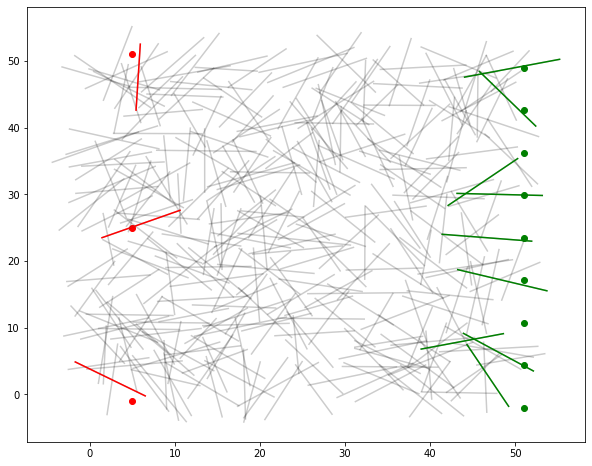

In [10]:
#Generate Network
%matplotlib inline

#find x and y values of each end of each wire 
xa=connectivity.xa[0]
xb=connectivity.xb[0]
ya=connectivity.ya[0]
yb=connectivity.yb[0]

#Pick Electrode placement/distance apart:

#DRAINS
numDrains=3
ex=np.ones(numDrains)*5#*15
# ey=np.linspace(0,550,numDrains)
ey=np.linspace(-1,51,numDrains)#(50,100,numDrains)

elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates

plt.figure(figsize=(10,8))
plt.scatter(ex, ey, c = 'r')

#SOURCES
numSources=9


#IN A LINE:
ex=np.ones(numSources)*51#95
ey=np.linspace(-2,49,numSources)#(35,100,numSources)
#IN A 3X3 GRID:
# middleNWx=int(connectivity.length_x/2)+1
# middleNWy=int(connectivity.length_y/2)-1
# distBwElecs=10
# ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
# ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates

plt.plot([xa, xb], [ya, yb], c = 'k',alpha=0.2)
plt.plot([xa[elecDrain], xb[elecDrain]], [ya[elecDrain], yb[elecDrain]], c = 'r')
plt.plot([xa[elecSource], xb[elecSource]], [ya[elecSource], yb[elecSource]], c = 'g')

plt.scatter(ex, ey, c = 'g')

# plt.savefig(figLoc+'Network and Electrodes.png',dpi=300)

In [11]:
print('OG Sources:' + str(elecSource))
print('OG Drains:' + str(elecDrain))

OG Sources:[183 322 194  74 145 317 196 342 141]
OG Drains:[296 249 339]


In [12]:
#MANUAL SOURCES DRAINS IF THERE'S OVERLAP
elecSource=[23,320,26,74,145,317,129,247,141] #elecSource=[39,253,155,33,271,25,185,163,256]
elecDrain=[296,249,25]#elecDrain=[306,317,53]

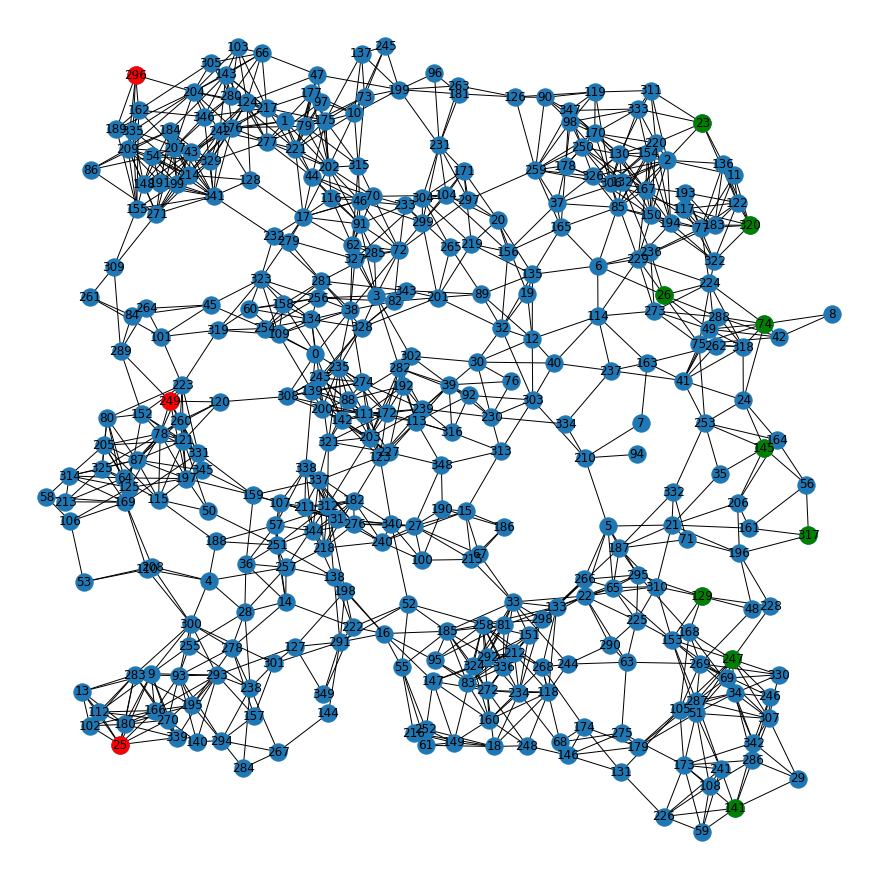

In [13]:
#PLOT GRAPH REPRESENTATION:
plt.figure(figsize=(12,12))
pos=nx.kamada_kawai_layout(nx.from_numpy_array(connectivity.adj_matrix))
nx.draw(nx.from_numpy_array(connectivity.adj_matrix),pos=pos,with_labels=True)
nx.draw_networkx_nodes(elecSource,node_color='g',pos=pos)
nx.draw_networkx_nodes(elecDrain,node_color='r',pos=pos)

In [14]:
#This function sets up the stimuli for simulations. 
def setupStimulus(training_stimulus,currInput,run_time=2,onAmp=1,signalType='DC'):

    for i in range(num_drain_training):
        training_stimulus.append((stimulus__(biasType='Drain',T=run_time,dt=dt)))
        
    #Sources
    for i in range(len(currInput)):
        if currInput[i]>0:
            training_stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp*currInput[i],T=run_time,dt=dt)))
#         else: #non-active sources are changed to 0.005 instead of 0, to reduce sink behaviour between sources
#             training_stimulus.append((stimulus__(biasType=signalType,onAmp=0.01,T=run_time,dt=dt)))

    return training_stimulus

In [15]:
#This function sets up the stimuli for the testing part of the simulation. 
def setupSourcesOnly(stim,currInput,onAmp=1,run_time=2,signalType='DC'):
    #Sources
    stimulus=copy.deepcopy(stim)
    for i in range(len(currInput)):
        if currInput[i]>0:
            stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp*currInput[i],T=run_time,dt=dt)))
#         else:
#             stimulus.append((stimulus__(biasType=signalType,onAmp=0.01,T=run_time,dt=dt)))
    return stimulus

In [16]:
#This function runs each training epoch and saves the network state at the last timestep of that epoch

def getNWState(training_stimulus,state,drain_pool,sources,run_time=2):
    eles = np.append(drain_pool, sources) #all drains
#     if len(eles) == num_drain_training + num_source_training:
    training_sim = runSim(connectivity, stimulus = training_stimulus,
                       junctionMode = 'tunneling',
                       dt = dt, T = run_time, 
                       contactMode = 'preSet',
                       electrodes = eles,
                       findFirst = False,
                       start_state = state,
                       disable_tqdm=True)
                       #criticalFlux=0.01)  
    JS1 = getJunctionState(training_sim, -1) #save state
#     else: 
#         print('Bless you Joel :)')
    return training_sim,JS1

In [17]:
#This function calculates the conductance read out at each drain electrode, 
#which we use to determine if the target threshold for each electrode is met

def calcOutputs(sim2, sources,all_drains):
    
    cc = np.zeros(len(all_drains))
    volt = np.zeros(len(all_drains))

#     for i, d in enumerate(all_drains):
#         a = wireCurrentTimeSeries(sim1, d)
#         b = wireCurrentTimeSeries(sim2, d)
#         print(a.shape,b.shape)
#         cc[i] = np.dot(a.reshape(-1),b.reshape(-1))

#     cc=(cc-minval)/(maxval-minval)
#       return cc

# ALTERNATIVE METHOD SUGGESTED BY JOEL


#Index network state:
    #IF PULSE - we want the state of the network at the end of the last pulse 
    if sim2.stimulus[-1].biasType=='Pulse':
        t=sim2.stimulus[-1].signal>0.005
        idx=[i for i, x in enumerate(t) if x][-1]
    else: #otherwise we take 4 timesteps as the state of the network 
#         idx=[500,1000,1500,-1]
        idx=-1
        
        
#Calculate Current at network state: 
    for i, d in enumerate(all_drains): #for each drain electrode
        #current
        cc[i]=sim2.electrodeCurrent.T[i][idx]#/(sim2.wireVoltage.T[sources[0]][idx]-sim2.wireVoltage.T[d][idx])
        #resistance
        volt[i]=sim2.wireVoltage.T[d][idx]#/sim2.electrodeCurrent.T[i][idx]
        
        # Conductance = Current Drain / (Voltage Source - Voltage Drain)
    return cc,volt


In [18]:
#Calculate cost function
def calc_cost(x,y):
    return (1/2)*((x-y)**2)
#we need to account for the fact where some non-target drains will have -ve current that impacts the +ve current drains

In [19]:
#This function changes the write voltage of the drain electrodes. This is where we tune the system so that 
#it prioritises/de-prioritises certain pathways based on targets and non-targets
def change_voltage(stim,sim2,outputVals,target_index,th=0,th2=0,signalType='DC'):
    import copy
    stimulus=copy.deepcopy(stim)
    
    Vi        = np.zeros((int(run_time/dt)))
    maxV      = onAmp*0.75
    n         = len(outputVals)
    cost      = np.zeros(n)
    beta      = 0.1 #change the values here
    grad      = np.zeros((n))
    dsig    = np.array([stimulus[i].signal for i in range(len(stimulus))][:num_drain_training])
    
    #vectorised implementation
    cost=calc_cost(outputVals,target_values) 
    
#     if gradOff == False: #
    grad=beta*(outputVals-target_values) 
#     elif gradOff == True: #if we have hit currents target
#         grad=0
    dsig2=dsig.T+(grad*onAmp)
    for i in range(n): # for each drain:
        if stimulus[i].signal[0] <= maxV and stimulus[i].signal[0] >= -maxV:
            stimulus[i].signal=dsig2.T[i]
        
#         stop  = False
#         stop2 = False
        
#         if i == target_index: #if it is a target drain: 
#             if outputVals[i] > (th - 0.1) and outputVals[i] < th: #if we're in the range of 0.8 to 1
#                 stop    = True
                
#             currentVal=outputVals[i]
            
#             #calculate cost
#             cost[i]     = calc_cost(currentVal,th) #current squared dimensions            
#             #calculate gradient
#             if stop == False:
#                 grad[i] = beta*(currentVal-th) 
#             else:
#                 grad[i] = 0
                
            #change voltage    
#             if stimulus[i].signal[0] <= maxV and stimulus[i].signal[0] >= -maxV:
#             stimulus[i].signal += (Vi+grad[i])*onAmp #change voltage using gradient & convert to input voltage
        
#         else: #if it is a non-target drain:
            
#             #if we're in the range of 0 to 0.2
# #             if outputVals[i] < (th2):
# #                 outputVals[i] = th2
#             if outputVals[i] < (th2 + 0.1) and outputVals[i] > th2:
#                 stop2   = True
            
#             currentVal=outputVals[i]
            
#             #calculate cost
#             cost[i]     = calc_cost(currentVal,th2)
#             #calculate gradient
#             if stop2 == False:
#                 grad[i] = beta*(currentVal-th2)
#             else:
#                 grad[i] = 0
                
            #change voltage   
#             if stimulus[i].signal[0] <= maxV and stimulus[i].signal[0] >= -maxV:
#             stimulus[i].signal += (Vi+grad[i])*onAmp
                
            #diff between target and output
            
#     print('Normalized Currents '+str(outputVals))
    print('Costs '+str(cost))
    print('Sum Cost '+str((np.sum(cost))))
    print('Gradients '+str(grad))
    return outputVals,stimulus,cost

In [20]:
#This function combines all the training functions into one step:

def runSimulations(stimulus,state,signalType,run_time=2):
    #first we run the training for this epoch, and get the network state at the last timestep:
    simulation,new_state = getNWState(stimulus,state,drain_pool,onSources,run_time=run_time) 
    #we then calculate the drain currents at that network state
    t,v      = calcOutputs(simulation,sources,drain_pool)
    return t,v,new_state,simulation

#This is how we test new inputs - only care about cost
def runTesting(outputVals,th,th2):
    n     = len(outputVals)   
    cost=calc_cost(outputVals,target_values) 
    return cost


In [23]:
sources = elecSource
drain_pool = elecDrain
allTargets=onehot_outputs#[[1,0,0],[0,1,0],[0,0,1]]
numSamples=10

In [22]:
# # SET UP INPUTS FOR TRAINING + TESTING
# orig_inputs=np.zeros(1)
# #Simple Patterns + NOISE
# orig_inputs=np.array((np.array([1,1,1,0,0,0,0,0,0]),np.array([0,0,0,1,1,1,0,0,0]),np.array([0,0,0,0,0,0,1,1,1])))
# orig_inputs=orig_inputs.astype('double')
# samples=[[] for i in range(len(orig_inputs))]
# new_inputs=np.array([orig_inputs]*10)

# #Pattern without Noise
# NoNoiseInputs=[]
# for targetClass in range(3):
#     NoNoiseInputs.append([int(i) for i in orig_inputs[targetClass]])

# #Make Noisy variants of simple patterns:
# for i in range(len(orig_inputs)):
#     for j in range(numSamples):
#         randVals=np.random.randint(1,3) #choose how many of the 3 sources will have noise
#         noiseVals=np.random.randint(3, size=randVals)
#         temp=orig_inputs[i][orig_inputs[i]==1].astype('double')
#         for val in noiseVals:
#             temp[val]=np.double(np.random.random(1))
#         new_inputs[j][i][new_inputs[j][i]==1]=temp
# #         samples[i].append(temp)

In [24]:
inputs

array([[1., 1., 1., 0., 1., 0., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1., 0., 1., 1., 1., 1.],
       [1., 0., 1., 0., 1., 0., 1., 1., 1., 1.],
       [1., 1., 0., 0., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 0., 0., 1., 1., 1.],
       [1., 1., 1., 0., 1., 0., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1., 0., 1., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 1., 0., 1.],
       [1., 1., 1., 0., 1., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 1., 0., 1.],
       [1., 0., 1., 1., 1., 0., 0., 1., 0., 1.],
       [1., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0., 0., 1., 1., 1.],
       [1., 0., 1., 

In [29]:
#Split into Training and Testing:
targetClass     = 1#'z','v','n'
target_values=allTargets[targetClass]#allTargets[targets==targetClass][0]

if len(elecDrain) == 3:
    targetClassVals=[0,1,2]
else:
    targetClassVals=[0,1,2,3]
    target_values=np.hstack((target_values,0)) #add extra 0 for 4th drain that acts just to balance the network

trainingInputs  = inputs[targets==targetClassVals[targetClass]][:-2]#inputs[targetClass][:-2]#NoNoiseInputs[targetClass] #training set
testingInputs   = inputs[targets==targetClassVals[targetClass]][-2:]#inputs[targetClass][-2:]#inputs[targets==targetClassVals[targetClass]][-2:] #test set